# Generate MNIST Real-Valued Dataset

## Constants

In [95]:
import numpy as np
import os
import tensorflow as tf
import random as rn
from keras import backend as K

### Set random seed Everywhere

In [96]:
seed = 123
rand = np.random.RandomState(seed)
os.environ['PYTHONHASHSEED'] = '{}'.format(rand.randint(2**32))
np.random.seed(rand.randint(2**32))
rn.seed(rand.randint(2**32))
tf.random.set_seed(rand.randint(2**32))

### Make TensorFlow deterministic

In [97]:
# Make TensorFlow deterministic:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(config=session_conf)
K.set_session(sess)
# Even after all this machinery the weights are only ε-close

### Import MNIST

In [98]:
X_raw = mnist['data'].reshape(70000,28,28,1)
X_raw = X_raw.astype('float32')/255
X_raw.shape

(70000, 28, 28, 1)

In [99]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', data_home="./")
X_raw = mnist['data'].reshape(70000,28,28,1)
X_raw = X_raw.astype('float32')/255
y = np.array(mnist['target'], dtype=int)
num_classes = len(np.unique(y))
print(X_raw.shape)

(70000, 28, 28, 1)


### Visualize MNIST

In [100]:
y

array([5, 0, 4, ..., 4, 5, 6])

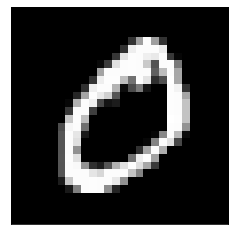

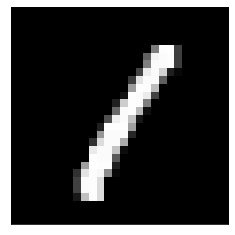

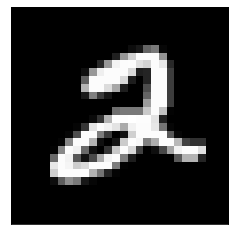

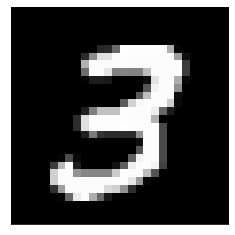

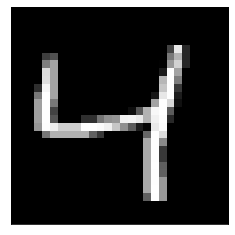

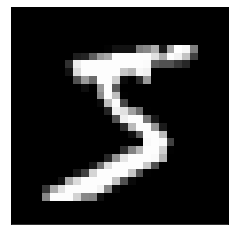

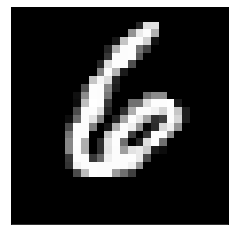

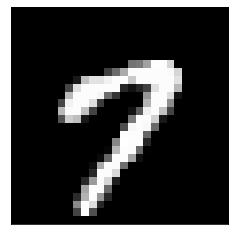

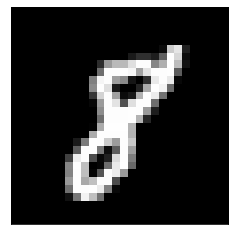

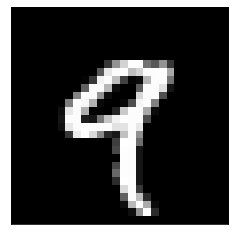

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    idx = np.where(y==i)[0][0]
    plot_file =  "{}.png".format(i)
    fig, ax = plt.subplots()
    ax.imshow(X_raw[idx], cmap = 'gray')
#     print('shape of x: ',X_raw[idx].shape)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.savefig(plot_file, dpi=80, facecolor='w', edgecolor='w', orientation='portrait', format='png')

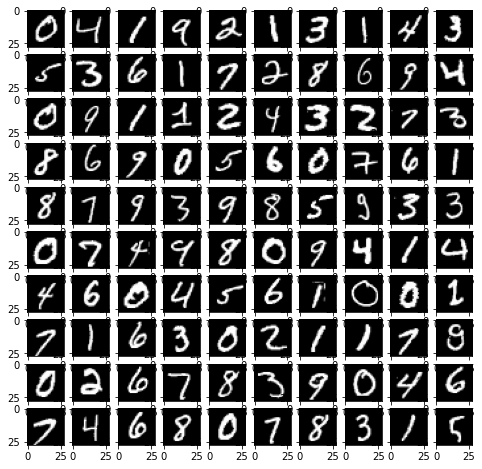

In [102]:
%matplotlib inline

import matplotlib.pyplot as plt
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = X_raw[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

### Split into Train/test

In [103]:
from sklearn.model_selection import train_test_split
test_size = 60000
X_raw_train, X_raw_test, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=test_size,
    random_state=rand,
    stratify=y
)

In [104]:
X_raw_train.shape, X_raw_test.shape

((10000, 28, 28, 1), (60000, 28, 28, 1))

In [105]:
y_train.shape

(10000,)

In [106]:
# Final dataset:
n_train = X_raw_train.shape[0]
n_test = X_raw_test.shape[0]

# Final transformed features:
n_features = 128

### Construct a CNN

In [115]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from tensorflow.python.framework.ops import disable_eager_execution



regularizer = l2(1e-4)

input_shape = (28, 28, 1)
input_layer = Input(input_shape)
#Define the architecture here
previous_layer= layers.Conv2D(filters=6,kernel_size=(5,5),activation='relu')(input_layer)
previous_layer=layers.MaxPooling2D((2,2))(previous_layer)
previous_layer=layers.Conv2D(filters=16,kernel_size=(5,5),activation='relu')(previous_layer)
# previous_layer=layers.MaxPooling2D((2,2))(previous_layer)

# previous_layer=layers.GlobalAveragePooling2D()(previous_layer)
previous_layer=layers.Flatten()(previous_layer)
previous_layer=layers.Dense(1024, activation='relu', kernel_regularizer=regularizer)(previous_layer)
intermediate_layer=layers.Dense(128, activation='relu', kernel_regularizer=regularizer)(previous_layer)
output_layer=layers.Dense(10, activation='softmax', kernel_regularizer=regularizer)(intermediate_layer)


# intermediate_layer = Dense(n_features, ....)(previous_layer)
# outut_layer = Dense(10, activation='softmax', kernel_regularizer=regularizer)(intermediate_layer)
# disable_eager_execution()
model = Model(inputs=input_layer, outputs=output_layer)

In [116]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 8, 8, 16)          2416      
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_46 (Dense)             (None, 128)               131

### Construct an Intermediate Model for Feature extraction

In [117]:
model_transformer = Model(inputs=input_layer,outputs=intermediate_layer)
model_transformer.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 8, 8, 16)          2416      
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_46 (Dense)             (None, 128)               131

### Train the model

In [118]:
from tensorflow.keras.utils import to_categorical

test_labels = to_categorical(y_test,10)
train_labels = to_categorical(y_train,10)

print(train_labels.shape)
print(test_labels.shape)

(10000, 10)
(60000, 10)


In [119]:
# Choose the categorical_crossentropy loss function and the optimizer of your choice
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(X_raw_train[..., None], keras.utils.np_utils.to_categorical(y_train, num_classes),
#           batch_size=64, epochs=15, verbose=1, validation_split=0.1, callbacks=[lrschedule])

model.fit(X_raw_train, train_labels,
          batch_size=64, epochs=14,validation_split=0.1)#,callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)])

Epoch 1/14
141/141 [==============================] - 4s 28ms/step - loss: 0.5393 - accuracy: 0.8662 - val_loss: 0.2913 - val_accuracy: 0.9510
Epoch 2/14
141/141 [==============================] - 4s 27ms/step - loss: 0.2486 - accuracy: 0.9568 - val_loss: 0.2635 - val_accuracy: 0.9450
Epoch 3/14
141/141 [==============================] - 4s 27ms/step - loss: 0.1916 - accuracy: 0.9701 - val_loss: 0.2500 - val_accuracy: 0.9470
Epoch 4/14
141/141 [==============================] - 4s 26ms/step - loss: 0.1570 - accuracy: 0.9806 - val_loss: 0.2213 - val_accuracy: 0.9570
Epoch 5/14
141/141 [==============================] - 4s 27ms/step - loss: 0.1351 - accuracy: 0.9849 - val_loss: 0.1878 - val_accuracy: 0.9740
Epoch 6/14
141/141 [==============================] - 4s 27ms/step - loss: 0.1169 - accuracy: 0.9900 - val_loss: 0.2178 - val_accuracy: 0.9620
Epoch 7/14
141/141 [==============================] - 4s 27ms/step - loss: 0.1108 - accuracy: 0.9899 - val_loss: 0.1975 - val_accuracy: 0.9660

### Evaluate the CNN

In [120]:
model.evaluate(X_raw_test,test_labels)

1875/1875 [==============================] - 11s 6ms/step - loss: 0.1433 - accuracy: 0.9763


[0.14326192438602448, 0.9763000011444092]

In [113]:
len(X_raw_test)

60000

### Use CNN to transform images to real numbered high level features

In [123]:
X_raw_feat = model_transformer.predict(X_raw_test)

In [126]:
np.save("X_raw_features.npy", X_raw_feat)
np.save("y_labels.npy", y_test)

In [124]:
X_raw_feat.shape

(60000, 128)

In [125]:
X_raw_feat

array([[4.6506    , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [7.0014806 , 0.        , 3.929787  , ..., 0.        , 0.        ,
        0.        ],
       [0.25379688, 0.        , 2.4603567 , ..., 0.        , 0.        ,
        0.5395717 ],
       ...,
       [6.985276  , 0.        , 4.315971  , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.7774942 , ..., 0.        , 0.        ,
        0.2721149 ],
       [0.        , 0.        , 0.728336  , ..., 0.        , 0.        ,
        4.1661334 ]], dtype=float32)